In [1]:
# This code works in Python 3.10.6
import os
import torch
import dgl
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import torch_geometric.utils.convert
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(1, '../../../evaluation/')
sys.path.insert(1, '../../model/')
sys.path.insert(1, '../../postprocessing/')
sys.path.insert(1, '../../select_explanation/')

In [3]:
import plots
import utils
import imdb_model as GNN
import imdb_postprocessing as postprocessing
import imdb_select_explanation as select_explanation

In [4]:
FEATURE_SIZE = 5
RUNS = 10

Create Metagraph

In [5]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [6]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original IMDB dataset with all node features

In [7]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [8]:
movie_data = data['movie'].x
df_movie = pd.DataFrame(movie_data)
            
imp_feat_movie = utils.selected_features_var(data['movie'].x, threshold=0.93).iloc[:, : FEATURE_SIZE]
imp_feat_movie.head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [9]:
data['movie'].x = torch.tensor(imp_feat_movie.values).to(dtype=torch.float32)

Dataset with selected node features used for GNN training

In [10]:
data

HeteroData(
  movie={
    x=[4278, 5],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [11]:
#Reading from files, the generated node features using diffusion(TabDDPM)
class_path = '../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/tabddpm/imdb/'
class0  = pd.DataFrame(np.load(class_path + 'movie0_tabddpm_variance5.npy',allow_pickle=True))
class1  = pd.DataFrame(np.load(class_path + 'movie1_tabddpm_variance5.npy',allow_pickle=True))
class2  = pd.DataFrame(np.load(class_path + 'movie2_tabddpm_variance5.npy',allow_pickle=True))

#Download from https://drive.google.com/file/d/1cYWwO4WgfafH3G0bOw69DQsLAFUiJs-5/view as in initial setup(refer to README.md)and 
#reference the .npy files for director and actor as below
director  = pd.DataFrame(np.load(class_path + 'imdb_features_tabddpm/imdb/director_tabddpm.npy',allow_pickle=True))
actor  = pd.DataFrame(np.load(class_path + 'imdb_features_tabddpm/imdb/actor_tabddpm.npy',allow_pickle=True))

df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)

In [12]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [13]:
import glob
graphs_path = '../../../graph generator/diffusion models/sampled_graphs_diffusion/'
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'imdb_5to10/*.gexf')]))

Original no of graphs: 1367


In [14]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [15]:
for i in range(0,RUNS):   
    
    model = GNN.HAN(data.metadata(), in_channels=-1, out_channels=3)
    
    device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 700):  
        loss = GNN.train(data,model,optimizer)
        train_acc, val_acc, test_acc = GNN.test(data,model)
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                  f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break
    
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}
    
    #Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
    for filepath in glob.iglob(graphs_path + 'imdb_5to10/*.gexf'):
        
        graph = nx.read_gexf(filepath)
        
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]
        
        nodeId_list = []
        node_type_list = []
    
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
    
        
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
      
    
        nodes,edges,movie_node_features,director_node_features,actor_node_features= postprocessing.get_node_features(graph,
                                                df_class0,df_class1,df_class2,director,actor)
        small_graph_data, removed_edges, graph_edges = postprocessing.create_dataset(nodes,edges,
                                  movie_node_features,director_node_features,
                                  actor_node_features,graph_id,df_graph)
        
        all_edges.update(graph_edges)
        edge_list = all_edges[graph_id]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):
        
            if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) and \
                (small_graph_data['movie','to','actor']) and \
                (small_graph_data['movie','to','director']) and \
                (small_graph_data['director','to','movie']):
                
                small_graph_data= small_graph_data.to(device)
                softmax = select_explanation.evaluate_gnn(small_graph_data,model)
                softmax_dict[graph_id] = softmax
                nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x,
                                                 'director':small_graph_data['director'].x,
                                                 'actor':small_graph_data['actor'].x}
                graph_dict[graph_id]=df_graph

    print("No. of graphs evaluated: ",len(softmax_dict))

    avg_max_pred, max_pred, class_graphid = select_explanation.get_max_pred(softmax_dict,i)

    avg_max_pred_list.append(avg_max_pred)
    max_pred_list.append(max_pred)
    graph_dict_list.append(graph_dict)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    all_edges_list.append(all_edges)
    class_graphid_list.append(class_graphid)

Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run0 1.0 0.9999997615814209 0.9999973773956299
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run1 1.0 0.9999998807907104 1.0
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run2 1.0 1.0 0.8293122053146362
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run3 1.0 1.0 0.9799450635910034
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run4 1.0 1.0 0.8811290860176086
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run5 1.0 1.0 0.9999916553497314
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run6 1.0 1.0 0.9794585704803467
Epoch: 200, Loss: 0.0664, Train: 1.0000, Val: 0

In [16]:
avg_max_pred_list

[0.9999990463256836,
 0.9999999602635702,
 0.943104068438212,
 0.9933150211970011,
 0.9603763620058695,
 0.9999972184499105,
 0.9931528568267822,
 0.9999997615814209,
 1.0,
 1.0]

In [17]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.9889944295088451


In [18]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.019202932634761208


In [19]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

8

In [20]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]

In [21]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]

In [22]:
all_edges = all_edges_list[index]

In [23]:
graph_dict = graph_dict_list[index]

In [24]:
softmax_dict = softmax_dict_list[index]

In [25]:
nodefeature_dict = nodefeature_dict_list[index]

In [26]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graphs and node features for each class of Movie node

Node colors:

Director - Blue

Actor - Red

Movie - Darkgreen

Number of nodes:  9
graph id:  graph1000
Max pred probability for class 0 is 1.0


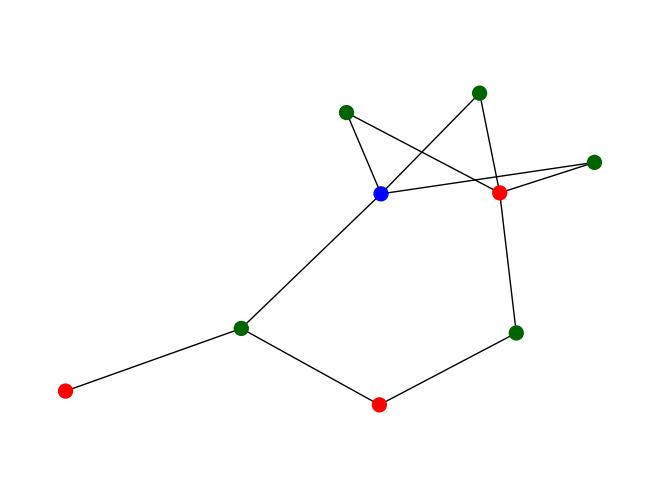

In [27]:
explanation_graph0 = plots.plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [28]:
ind= utils.index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].cpu().numpy()[ind]
Counter(list0)

Counter({0.0: 4, 1.0: 1})

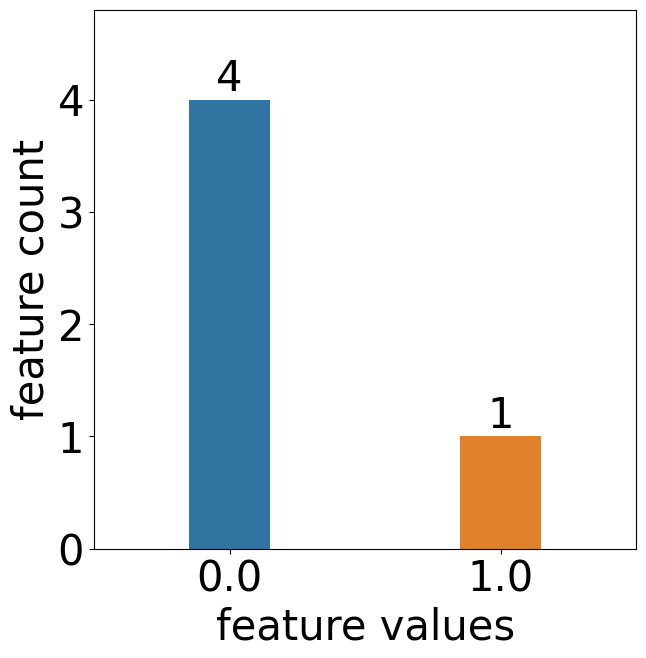

In [29]:
plots.count_plot(list0)

Number of nodes:  5
graph id:  graph1
Max pred probability for class 1 is 1.0


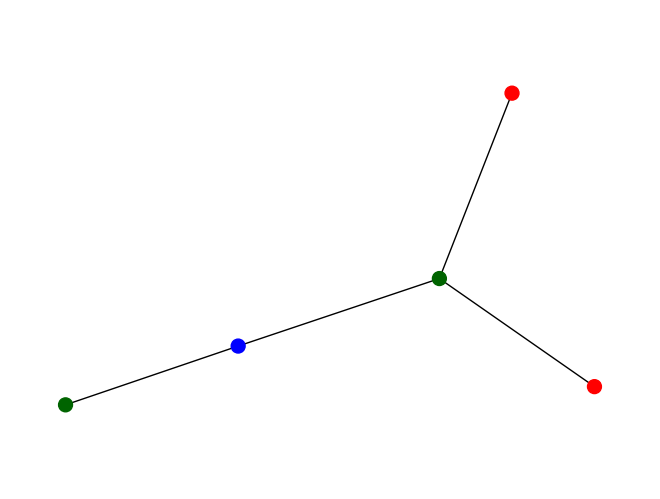

In [30]:
explanation_graph1 = plots.plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [31]:
ind= utils.index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].cpu().numpy()[ind]
Counter(list1)

Counter({0.0: 4, 1.0: 1})

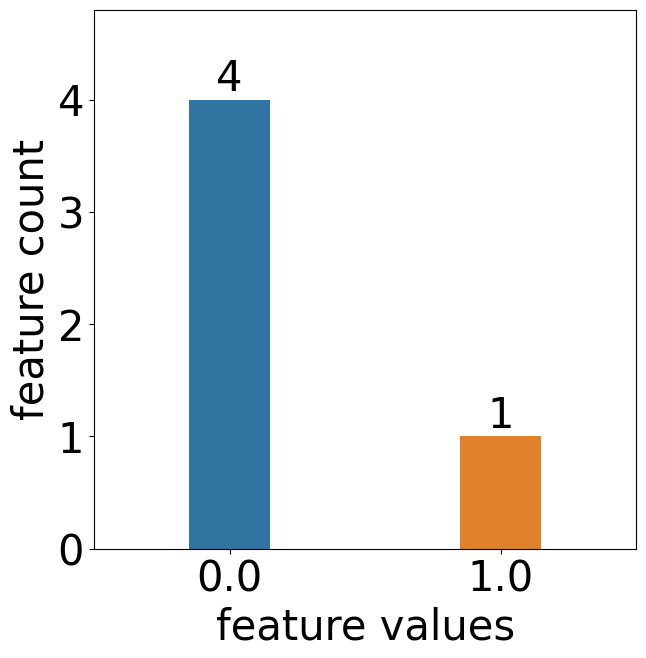

In [32]:
plots.count_plot(list1)

Number of nodes:  9
graph id:  graph1021
Max pred probability for class 2 is 1.0


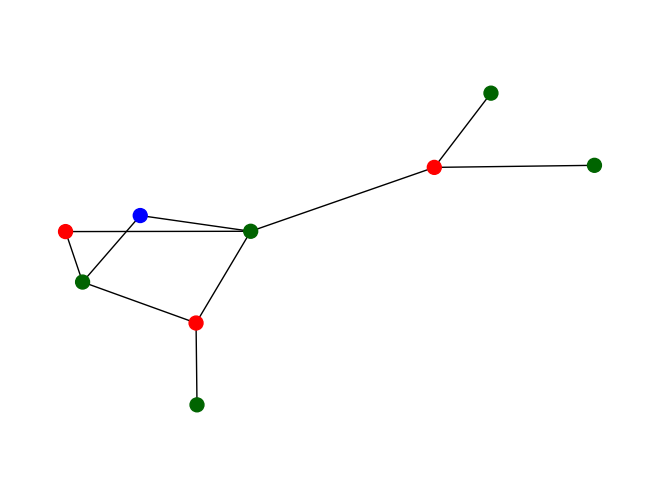

In [33]:
explanation_graph2 = plots.plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [34]:
ind= utils.index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].cpu().numpy()[ind]
Counter(list2)

Counter({0.0: 5})

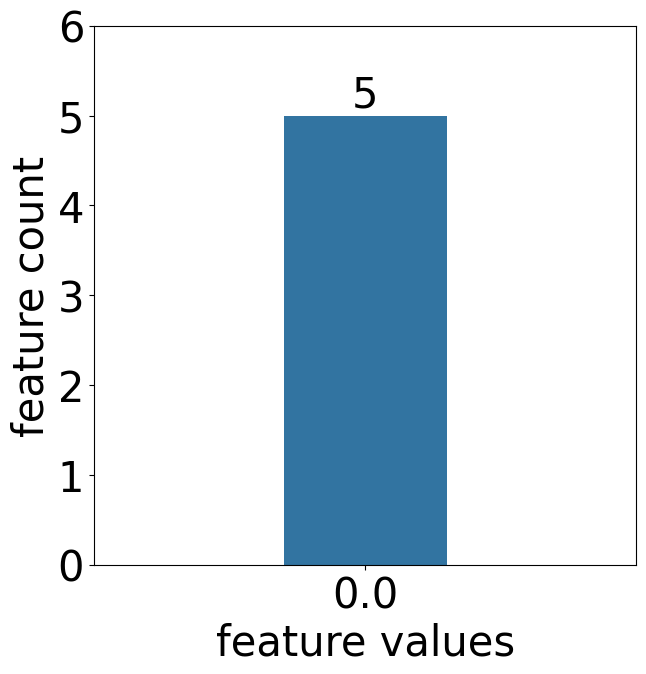

In [35]:
plots.count_plot(list2)

In [36]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].cpu().numpy())
utils.print_stat_cont_features(actor0_df)

mean 0.5204005
std dev 0.6208274


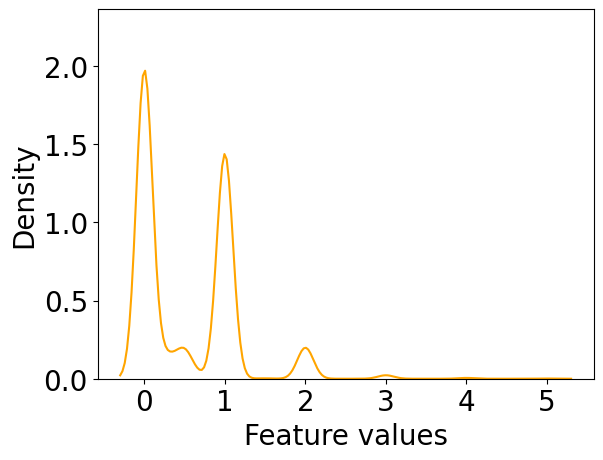

In [37]:
plots.plot_cont_feat(actor0_df)

In [38]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].cpu().numpy())
utils.print_stat_cont_features(actor1_df)

mean 0.5129977
std dev 0.6229172


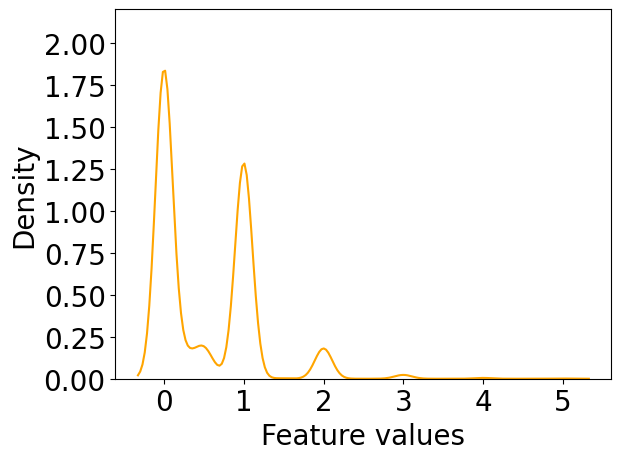

In [39]:
plots.plot_cont_feat(actor1_df)

In [40]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].cpu().numpy())
utils.print_stat_cont_features(actor2_df)

mean 0.5063228
std dev 0.6142758


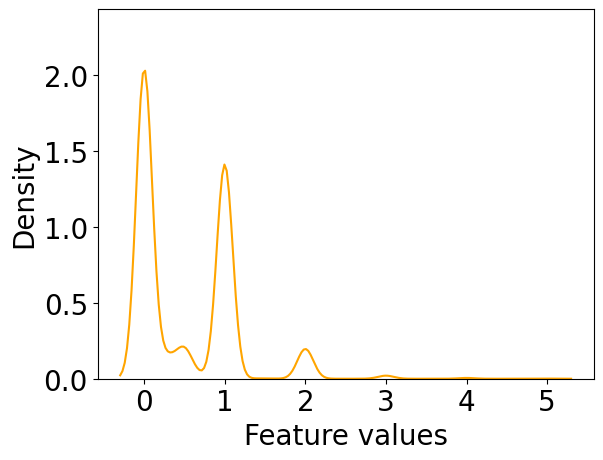

In [41]:
plots.plot_cont_feat(actor2_df)

In [42]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['director'].cpu().numpy())
utils.print_stat_cont_features(director0_df)

mean 0.4345746
std dev 0.5704978


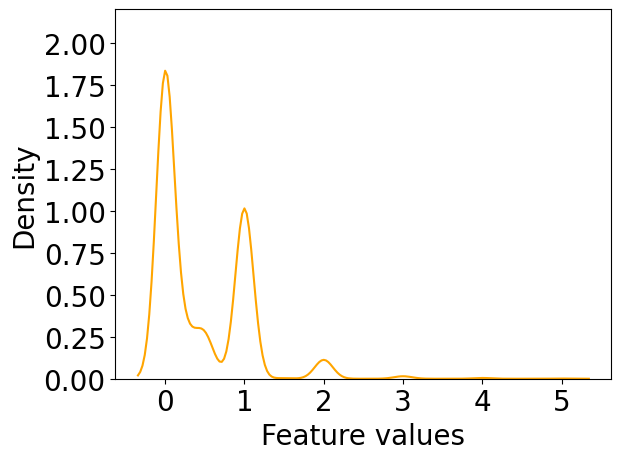

In [43]:
plots.plot_cont_feat(director0_df)

In [44]:
director1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['director'].cpu().numpy())
utils.print_stat_cont_features(director1_df)

mean 0.42053652
std dev 0.5728745


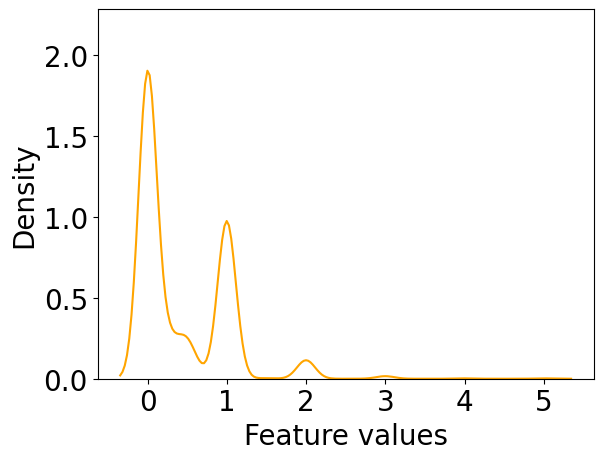

In [45]:
plots.plot_cont_feat(director1_df)

In [46]:
director2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['director'].cpu().numpy())
utils.print_stat_cont_features(director2_df)

mean 0.42053652
std dev 0.5728745


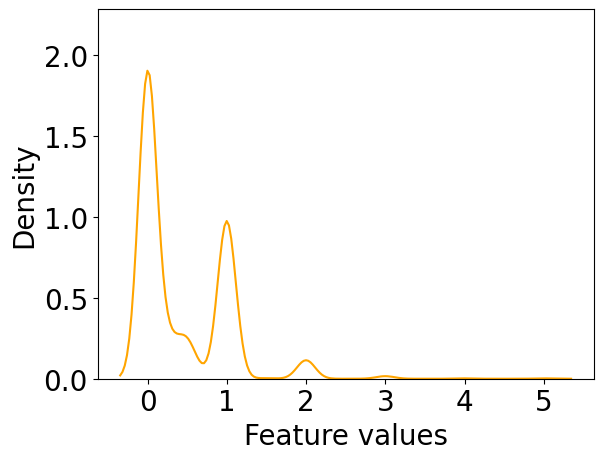

In [47]:
plots.plot_cont_feat(director2_df)

## Ground-truth faithfulness

In [48]:
motifs_path = '../../motifs/imdb/'

In [49]:
from os import walk
w = walk(motifs_path)

for (dirpath, dirnames, filenames) in w:
    print(dirpath,filenames)

motifs/imdb/ []
motifs/imdb/class0 ['motif_real_imdb_15.gexf', 'motif_real_imdb_16.gexf', 'motif_real_imdb_17.gexf', 'motif_real_imdb_23.gexf', 'motif_real_imdb_24.gexf', 'motif_real_imdb_25.gexf', 'motif_real_imdb_26.gexf', 'motif_real_imdb_36.gexf', 'motif_real_imdb_6.gexf', 'motif_real_imdb_7.gexf']
motifs/imdb/class1 ['motif_real_imdb_0.gexf', 'motif_real_imdb_1.gexf', 'motif_real_imdb_11.gexf', 'motif_real_imdb_20.gexf', 'motif_real_imdb_21.gexf', 'motif_real_imdb_32.gexf', 'motif_real_imdb_35.gexf', 'motif_real_imdb_38.gexf', 'motif_real_imdb_39.gexf', 'motif_real_imdb_9.gexf']
motifs/imdb/class2 ['motif_real_imdb_10.gexf', 'motif_real_imdb_13.gexf', 'motif_real_imdb_14.gexf', 'motif_real_imdb_2.gexf', 'motif_real_imdb_22.gexf', 'motif_real_imdb_27.gexf', 'motif_real_imdb_30.gexf', 'motif_real_imdb_33.gexf', 'motif_real_imdb_4.gexf', 'motif_real_imdb_8.gexf']


In [50]:
faithfulness_list = []

for i in range(0,RUNS):
    faithfulness = utils.get_faithfulness(class_graphid_list[i],all_edges_list[i],motifs_path)

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.9333333333333332
Run1 0.9666666666666667
Run2 0.8666666666666667
Run3 0.8666666666666667
Run4 0.8666666666666667
Run5 0.8666666666666667
Run6 0.9666666666666667
Run7 0.9
Run8 0.9
Run9 0.9666666666666667
Mean 0.9099999999999999


In [51]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.04229525846816506
